Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

from sklearn import metrics

from sklearn import tree

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv1D, Flatten, LeakyReLU, MaxPooling1D

from tensorflow.keras.losses import BinaryFocalCrossentropy

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Read in file to data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Ian Youn Session 4/drugsCom_raw/drugsComTrain_raw.tsv',sep='\t', header=0)
data.rename(columns = {'Unnamed: 0':'uniqueID'}, inplace = True)

# Data Exploration

In [4]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   uniqueID     161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
uniqueID,161297.0,115923.585305,67004.445170,2.0,58063.0,115744.0,173776.0,232291.0
rating,161297.0,6.994377,3.272329,1.0,5.0,8.0,10.0,10.0
usefulCount,161297.0,28.004755,36.403742,0.0,6.0,16.0,36.0,1291.0


In [7]:
data.nunique()

uniqueID       161297
drugName         3436
condition         884
review         112329
rating             10
date             3579
usefulCount       389
dtype: int64

In [8]:
data_num = data.drop(columns = ['uniqueID', 'drugName', 'condition', 'review', 'date'], inplace = False)

In [9]:
print(data['drugName'].value_counts(normalize = True))
print("-" * 50)
print(data['condition'].value_counts(normalize = True))
print(data['rating'].value_counts(normalize = True))

Levonorgestrel                       0.022672
Etonogestrel                         0.020682
Ethinyl estradiol / norethindrone    0.017669
Nexplanon                            0.013367
Ethinyl estradiol / norgestimate     0.013125
                                       ...   
Omnipaque 350                        0.000006
Vontrol                              0.000006
Ivabradine                           0.000006
Neo-Poly-Dex                         0.000006
Grifulvin V                          0.000006
Name: drugName, Length: 3436, dtype: float64
--------------------------------------------------
Birth Control                                              0.179479
Depression                                                 0.056541
Pain                                                       0.038311
Anxiety                                                    0.036808
Acne                                                       0.034838
                                                          

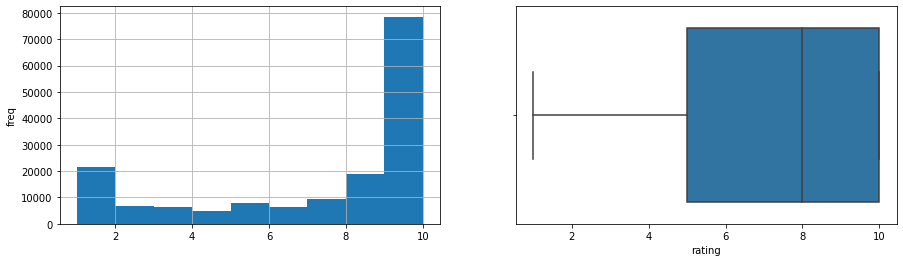

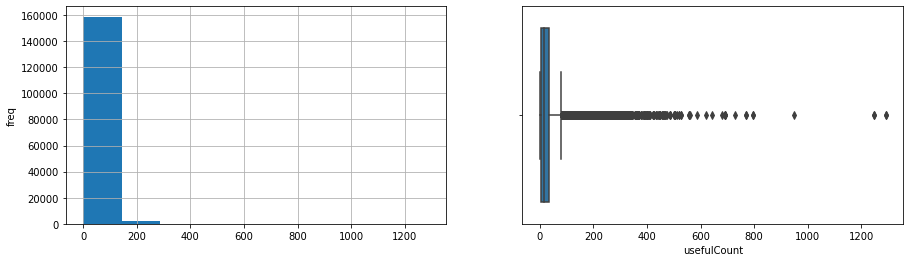

In [10]:
for col in data_num.columns:  
   plt.figure(figsize = (15, 4))
   plt.subplot(1, 2, 1)
   data_num[col].hist(bins=9)
   plt.ylabel('freq')
   plt.subplot(1, 2, 2)
   sns.boxplot(x = data_num[col])
   plt.show()

# Data Preprocessing

Contract Data

In [11]:
data = data[data.groupby('drugName')['drugName'].transform('size') > 20]
data = data.head(20000)

Remove contractions and punctuation

In [12]:
import re

data.dropna(inplace=True)

data['review'] = data['review'].str.lower()

contractions_dict = {'i&#039;ve' : 'i have', 'don&#039;t': 'do not', 'haven&#039;t': 'have not', 'didn&#039;t': 'did not', 'i&#039;m' : 'i am', 'wasn&#039;t': 'was not', 'it&#039;s': 'it is'}
regex=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(txt, contractions_dict = contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return regex.sub(replace, txt)
data['review'] = data['review'].apply(lambda a: expand_contractions(a))

data['review'] = data['review'].str.replace('(\&.*?\;)', '')
data['review'] = data['review'].str.replace('[^\w\s]', '')




In [13]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192
3,138000,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37
5,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2.0,"November 28, 2015",43


Remove stopwords and make wordcloud

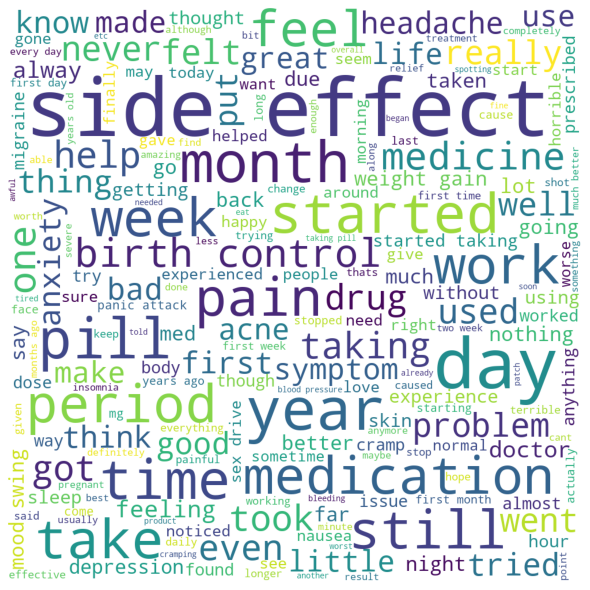

In [14]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.add('nan');
all_words = ''

def remove_stopwords(txt):
  if txt is not None:
    cell = str(txt).split()
  else:
    return '';
  filtered_sentence = []
  for w in cell:
    if w not in stop_words:
        filtered_sentence.append(w)
  return ' '.join(filtered_sentence)

data['review'] = data['review'].apply(lambda x: remove_stopwords(x))

for cell in data['review']: 
  all_words += ' '.join(cell.split())+' '

wordcloud = WordCloud(width = 1000, height = 1000, background_color ='white', min_font_size = 8).generate(all_words)
                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


  

Lemmatization

In [15]:
from nltk.stem import WordNetLemmatizer 

lm = WordNetLemmatizer()

def lem_words(txt):
  lemmed_sentence = []
  for w in txt.split():
    lemmed_sentence.append(lm.lemmatize(w))
  return ' '.join(lemmed_sentence)

data['review'] = data['review'].apply(lambda x: lem_words(x))

Convert rating into sentiment

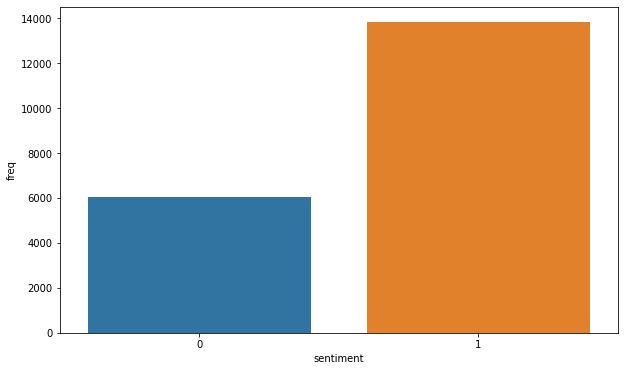

In [16]:
data['sentiment'] = np.where(data['rating'] > 5, 1, 0)

plt.figure(figsize = (10, 6))
sns.countplot(x = data['sentiment'], order=[0,1])
plt.ylabel('freq')
plt.show()

Check Correlations

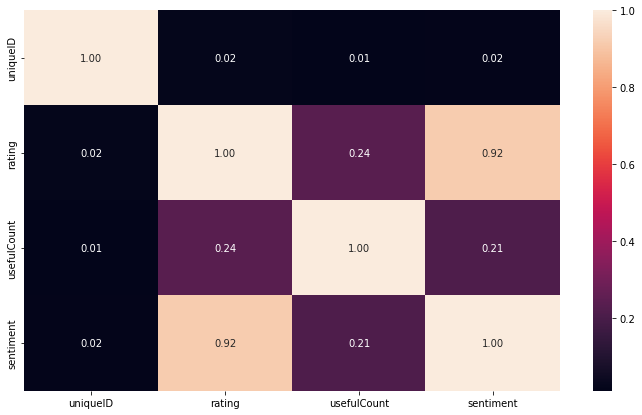

In [17]:
plt.figure(figsize = (12, 7))

sns.heatmap(data.corr(), annot = True, fmt = ".2f")

plt.show()

Split Data

In [18]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,side effect take combination bystolic 5 mg fis...,9.0,"May 20, 2012",27,1
1,95260,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8.0,"April 27, 2010",192,1
3,138000,Ortho Evra,Birth Control,first time using form birth control glad went ...,8.0,"November 3, 2015",10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone completely turned life around feel he...,9.0,"November 27, 2016",37,1
5,155963,Cialis,Benign Prostatic Hyperplasia,2nd day 5mg started work rock hard erection ho...,2.0,"November 28, 2015",43,0


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size = 0.33, random_state=0)

Use TfIdfVectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=5)

X_train_transformed = tfidf.fit_transform(X_train).astype('float32')
X_test_transformed = tfidf.transform(X_test).astype('float32')

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

d_tree =  DecisionTreeClassifier(random_state=0, class_weight = 'balanced')
d_tree.fit(X_train_transformed, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [21]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    print("bal accuracy: " + str(balanced_accuracy_score(actual, predicted)))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True,  fmt = '.2f', xticklabels = ['Negative', 'Positive'], yticklabels = ['Negative', 'Positive'])
    
    plt.ylabel('Actual')
    
    plt.xlabel('Predicted')
    
    plt.show()

              precision    recall  f1-score   support

           0       0.48      0.51      0.49      1997
           1       0.78      0.76      0.77      4563

    accuracy                           0.68      6560
   macro avg       0.63      0.63      0.63      6560
weighted avg       0.69      0.68      0.68      6560

bal accuracy: 0.6320470734591916


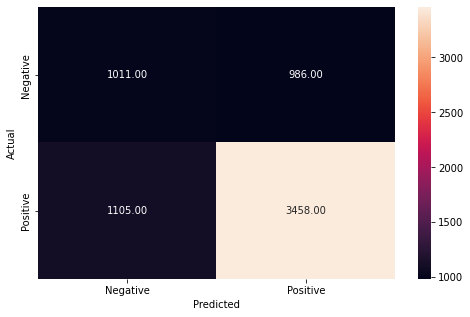

In [ ]:
y_pred_test = d_tree.predict(X_test_transformed)

metrics_score(y_test, y_pred_test)

Hyperparameter Tuning

In [ ]:
d_tree_tuned = DecisionTreeClassifier(random_state = 0, class_weight = 'balanced')

parameters = {'max_depth': np.arange(10, 30), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 5)
             }

grid = GridSearchCV(d_tree_tuned, parameters, scoring = 'balanced_accuracy', n_jobs = -1, cv = 5)
grid = grid.fit(X_train_transformed, y_train)

d_tree_tuned = grid.best_estimator_

d_tree_tuned.fit(X_train_transformed, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=25, random_state=0)

              precision    recall  f1-score   support

           0       0.45      0.59      0.51      1997
           1       0.79      0.68      0.73      4563

    accuracy                           0.66      6560
   macro avg       0.62      0.64      0.62      6560
weighted avg       0.69      0.66      0.67      6560

bal accuracy: 0.6369635540314635


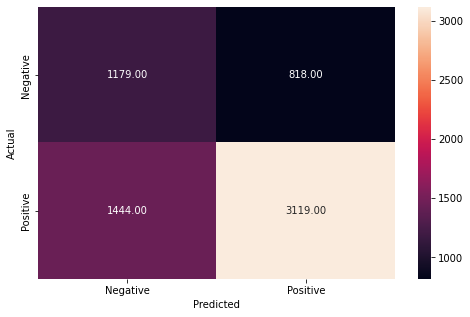

In [ ]:
y_pred_test = d_tree_tuned.predict(X_test_transformed)

metrics_score(y_test, y_pred_test)

Logistic Regression

              precision    recall  f1-score   support

           0       0.79      0.51      0.62      1997
           1       0.81      0.94      0.87      4563

    accuracy                           0.81      6560
   macro avg       0.80      0.72      0.75      6560
weighted avg       0.81      0.81      0.80      6560

bal accuracy: 0.7249206595341182


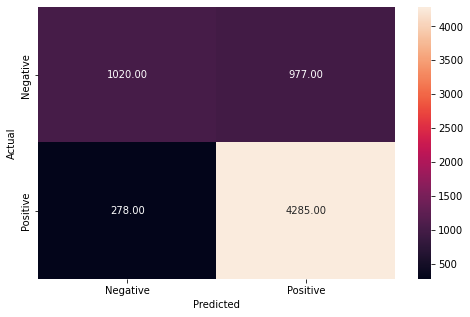

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_transformed, y_train)

y_pred_test = model.predict(X_test_transformed)

metrics_score(y_test, y_pred_test)

# XGBoost

              precision    recall  f1-score   support

           0       0.78      0.23      0.35      1997
           1       0.74      0.97      0.84      4563

    accuracy                           0.74      6560
   macro avg       0.76      0.60      0.60      6560
weighted avg       0.75      0.74      0.69      6560

bal accuracy: 0.5988151633542798


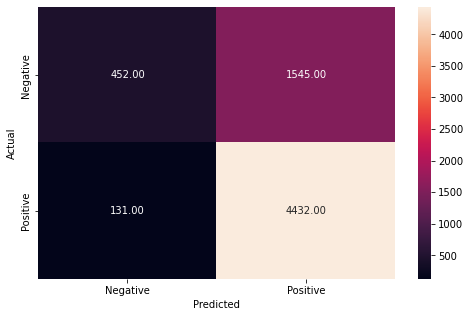

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(seed=42)

model.fit(X_train_transformed, y_train)

y_pred_test = model.predict(X_test_transformed)

metrics_score(y_test, y_pred_test)

Hyperparameter Tuning

In [ ]:
xgboost_tuned = XGBClassifier(n_jobs = -1, seed = 42, scale_pos_weight= 3/7)

parameters = {'max_depth': np.arange(2, 10),
    'n_estimators': np.arange(60, 240, 60),
    'learning_rate': [0.1, 0.01, 0.001]
             }

rand = RandomizedSearchCV(xgboost_tuned, parameters, scoring = 'balanced_accuracy', n_jobs = -1, cv=5)

rand = rand.fit(X_train_transformed, y_train)

xgboost_tuned = rand.best_estimator_

xgboost_tuned.fit(X_train_transformed, y_train)

XGBClassifier(max_depth=9, n_estimators=120, n_jobs=-1,
              scale_pos_weight=0.42857142857142855, seed=42)

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      1997
           1       0.86      0.81      0.83      4563

    accuracy                           0.77      6560
   macro avg       0.74      0.75      0.74      6560
weighted avg       0.78      0.77      0.78      6560

bal accuracy: 0.7524078140002026


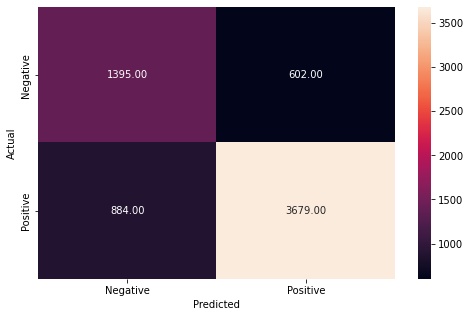

In [ ]:
y_pred_test = xgboost_tuned.predict(X_test_transformed)

metrics_score(y_test, y_pred_test)

# Neural Networks

In [23]:
from random import shuffle

np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

One Hot Encoding

In [22]:
y_train=to_categorical(y_train,2)
y_test=to_categorical(y_test,2)

In [24]:
def nn_model():
    model = Sequential()

    model.add(Dense(256, activation='relu', input_shape=(5715,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = nn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1463296   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [25]:
hist = model.fit(X_train_transformed.toarray(), y_train, batch_size = 128, verbose = 1, epochs = 20, validation_data = [X_test_transformed.toarray(), y_test], class_weight={0: 0.7, 1: 0.3})

Epoch 1/20
105/105 [==============================] - 6s 11ms/step - loss: 0.0621 - accuracy: 0.6761 - val_loss: 0.1564 - val_accuracy: 0.6976
Epoch 2/20
105/105 [==============================] - 1s 7ms/step - loss: 0.0349 - accuracy: 0.8673 - val_loss: 0.1383 - val_accuracy: 0.7044
Epoch 3/20
105/105 [==============================] - 1s 7ms/step - loss: 0.0141 - accuracy: 0.9544 - val_loss: 0.1169 - val_accuracy: 0.7899
Epoch 4/20
105/105 [==============================] - 1s 7ms/step - loss: 0.0040 - accuracy: 0.9895 - val_loss: 0.1262 - val_accuracy: 0.7988
Epoch 5/20
105/105 [==============================] - 1s 7ms/step - loss: 0.0019 - accuracy: 0.9950 - val_loss: 0.1844 - val_accuracy: 0.7913
Epoch 6/20
105/105 [==============================] - 1s 8ms/step - loss: 0.0011 - accuracy: 0.9968 - val_loss: 0.2534 - val_accuracy: 0.7965
Epoch 7/20
105/105 [==============================] - 1s 7ms/step - loss: 0.0020 - accuracy: 0.9927 - val_loss: 0.2777 - val_accuracy: 0.7905
Epoch

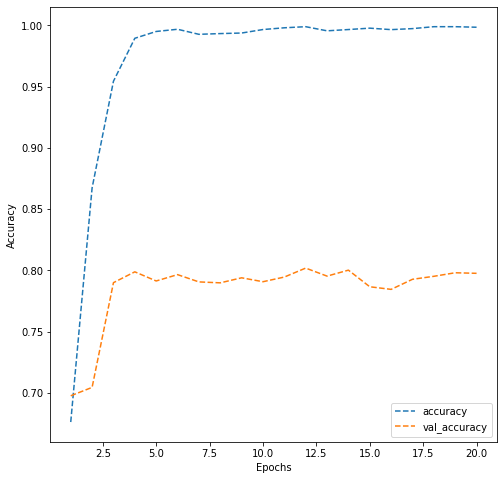

In [26]:
dict_hist = hist.history
list_ep = [i for i in range(1, 21)]
plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1997
           1       0.83      0.89      0.86      4563

    accuracy                           0.80      6560
   macro avg       0.77      0.74      0.75      6560
weighted avg       0.79      0.80      0.79      6560

bal accuracy: 0.7393085025302583


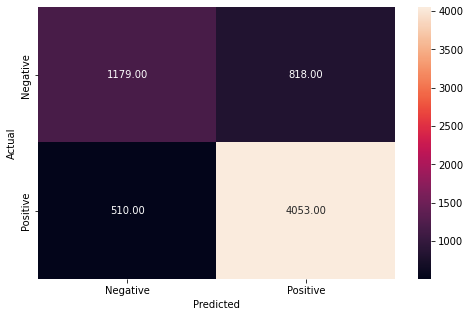

In [27]:
y_pred_test = model.predict(X_test_transformed.toarray())
y_pred_test=np.argmax(y_pred_test, axis=1)

metrics_score(np.argmax(y_test, axis=1), y_pred_test)

Convolutional Neural Network

In [28]:
X_train_transformed = X_train_transformed.toarray().reshape((X_train_transformed.toarray().shape[0], X_train_transformed.toarray().shape[1], 1))
X_test_transformed = X_test_transformed.toarray().reshape((X_test_transformed.toarray().shape[0], X_test_transformed.toarray().shape[1], 1))


In [35]:
def nn_model_2():
  model = Sequential()

  model.add(Conv1D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=X_train_transformed.shape[1:]))
  model.add(Dropout(0.2))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32,kernel_size=2,padding="same",activation="relu"))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512,activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(2,activation="softmax"))
    
  model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model_2 = nn_model_2()
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5715, 32)          128       
                                                                 
 dropout_6 (Dropout)         (None, 5715, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2857, 32)         0         
 )                                                               
                                                                 
 conv1d_4 (Conv1D)           (None, 2857, 32)          2080      
                                                                 
 dropout_7 (Dropout)         (None, 2857, 32)          0         
                                                                 
 flatten_2 (Flatten)         (None, 91424)             0         
                                                      

In [39]:
hist = model_2.fit(X_train_transformed, y_train, batch_size = 64, verbose = 1, epochs = 40, validation_data = [X_test_transformed, y_test], class_weight={0: 0.7, 1: 0.3})

Epoch 1/40
209/209 [==============================] - 6s 26ms/step - loss: 0.0563 - accuracy: 0.7343 - val_loss: 0.1106 - val_accuracy: 0.8032
Epoch 2/40
209/209 [==============================] - 5s 24ms/step - loss: 0.0413 - accuracy: 0.8265 - val_loss: 0.1180 - val_accuracy: 0.7895
Epoch 3/40
209/209 [==============================] - 5s 25ms/step - loss: 0.0279 - accuracy: 0.8912 - val_loss: 0.1347 - val_accuracy: 0.7832
Epoch 4/40
209/209 [==============================] - 5s 25ms/step - loss: 0.0134 - accuracy: 0.9539 - val_loss: 0.1626 - val_accuracy: 0.7860
Epoch 5/40
209/209 [==============================] - 5s 24ms/step - loss: 0.0057 - accuracy: 0.9835 - val_loss: 0.2110 - val_accuracy: 0.7928
Epoch 6/40
209/209 [==============================] - 5s 24ms/step - loss: 0.0023 - accuracy: 0.9938 - val_loss: 0.2546 - val_accuracy: 0.7915
Epoch 7/40
209/209 [==============================] - 5s 24ms/step - loss: 0.0017 - accuracy: 0.9954 - val_loss: 0.2588 - val_accuracy: 0.7957

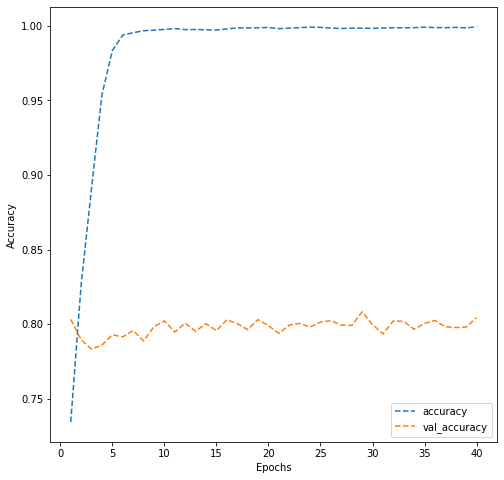

In [41]:
dict_hist = hist.history
list_ep = [i for i in range(1, 41)]
plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.70      0.63      0.66      1997
           1       0.84      0.88      0.86      4563

    accuracy                           0.80      6560
   macro avg       0.77      0.75      0.76      6560
weighted avg       0.80      0.80      0.80      6560

bal accuracy: 0.7545489832381709


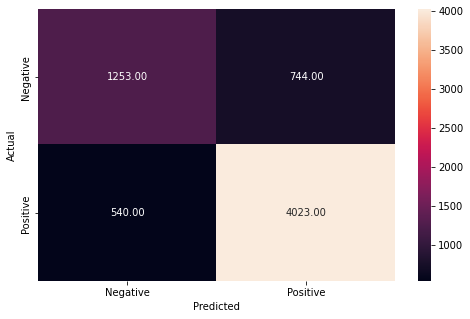

In [42]:
y_pred_test = model_2.predict(X_test_transformed)
y_pred_test=np.argmax(y_pred_test, axis=1)

metrics_score(np.argmax(y_test, axis=1), y_pred_test)

Using LeakyReLU

In [29]:
def nn_model_3():
  model = Sequential()

  model.add(Conv1D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=X_train_transformed.shape[1:]))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))
  model.add(Conv1D(filters=32,kernel_size=2,padding="same",activation="relu"))
  model.add(Flatten())
  model.add(Dense(512,activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(2,activation="softmax"))
    
  model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model_3 = nn_model_3()
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5715, 32)          128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5715, 32)          0         
                                                                 
 dropout_2 (Dropout)         (None, 5715, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5715, 32)          2080      
                                                                 
 flatten (Flatten)           (None, 182880)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               93635072  
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [30]:
hist = model_3.fit(X_train_transformed, y_train, batch_size = 64, verbose = 1, epochs = 40, validation_data = [X_test_transformed, y_test], class_weight={0: 0.7, 1: 0.3})

Epoch 1/40
209/209 [==============================] - 18s 37ms/step - loss: 0.0548 - accuracy: 0.7478 - val_loss: 0.1125 - val_accuracy: 0.7916
Epoch 2/40
209/209 [==============================] - 7s 34ms/step - loss: 0.0352 - accuracy: 0.8557 - val_loss: 0.1213 - val_accuracy: 0.7840
Epoch 3/40
209/209 [==============================] - 7s 34ms/step - loss: 0.0188 - accuracy: 0.9286 - val_loss: 0.1486 - val_accuracy: 0.7910
Epoch 4/40
209/209 [==============================] - 7s 34ms/step - loss: 0.0071 - accuracy: 0.9766 - val_loss: 0.2057 - val_accuracy: 0.7922
Epoch 5/40
209/209 [==============================] - 7s 34ms/step - loss: 0.0023 - accuracy: 0.9938 - val_loss: 0.2610 - val_accuracy: 0.7970
Epoch 6/40
209/209 [==============================] - 7s 34ms/step - loss: 0.0012 - accuracy: 0.9972 - val_loss: 0.2880 - val_accuracy: 0.7982
Epoch 7/40
209/209 [==============================] - 7s 34ms/step - loss: 8.9984e-04 - accuracy: 0.9976 - val_loss: 0.2992 - val_accuracy: 0

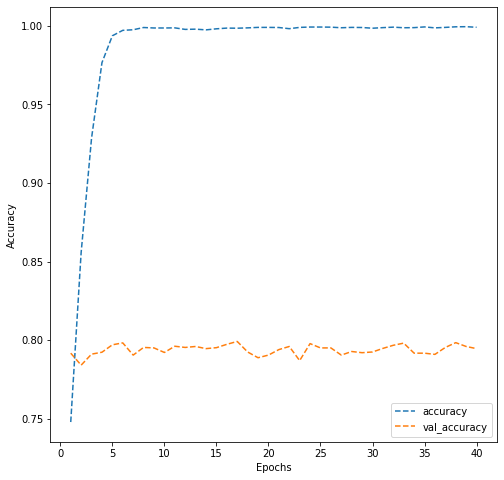

In [32]:
dict_hist = hist.history
list_ep = [i for i in range(1, 41)]
plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.66      0.67      0.67      1997
           1       0.86      0.85      0.85      4563

    accuracy                           0.79      6560
   macro avg       0.76      0.76      0.76      6560
weighted avg       0.80      0.79      0.80      6560

bal accuracy: 0.7602079209105133


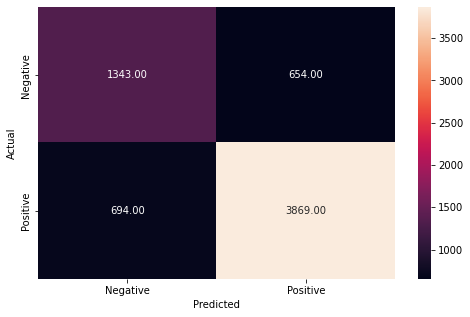

In [31]:
y_pred_test = model_3.predict(X_test_transformed)
y_pred_test=np.argmax(y_pred_test, axis=1)

metrics_score(np.argmax(y_test, axis=1), y_pred_test)

Using Max Pooling

In [43]:
def nn_model_4():
  model = Sequential()

  model.add(Conv1D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=X_train_transformed.shape[1:]))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))
  model.add(MaxPooling1D(2,2))
  model.add(Flatten())
  model.add(Dense(512,activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(2,activation="softmax"))
    
  model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model_4 = nn_model_4()
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 5715, 32)          128       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5715, 32)          0         
                                                                 
 dropout_9 (Dropout)         (None, 5715, 32)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2857, 32)         0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 91424)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               46809600  
                                                      

In [44]:
hist = model_4.fit(X_train_transformed, y_train, batch_size = 64, verbose = 1, epochs = 40, validation_data = [X_test_transformed, y_test], class_weight={0: 0.7, 1: 0.3})

Epoch 1/40
209/209 [==============================] - 6s 23ms/step - loss: 0.0549 - accuracy: 0.7465 - val_loss: 0.1087 - val_accuracy: 0.8058
Epoch 2/40
209/209 [==============================] - 5s 22ms/step - loss: 0.0388 - accuracy: 0.8380 - val_loss: 0.1169 - val_accuracy: 0.7895
Epoch 3/40
209/209 [==============================] - 4s 21ms/step - loss: 0.0257 - accuracy: 0.9000 - val_loss: 0.1312 - val_accuracy: 0.7902
Epoch 4/40
209/209 [==============================] - 4s 21ms/step - loss: 0.0119 - accuracy: 0.9613 - val_loss: 0.1595 - val_accuracy: 0.7939
Epoch 5/40
209/209 [==============================] - 4s 20ms/step - loss: 0.0042 - accuracy: 0.9901 - val_loss: 0.2012 - val_accuracy: 0.7986
Epoch 6/40
209/209 [==============================] - 4s 20ms/step - loss: 0.0016 - accuracy: 0.9961 - val_loss: 0.2262 - val_accuracy: 0.7970
Epoch 7/40
209/209 [==============================] - 4s 20ms/step - loss: 9.9892e-04 - accuracy: 0.9983 - val_loss: 0.2446 - val_accuracy: 0.

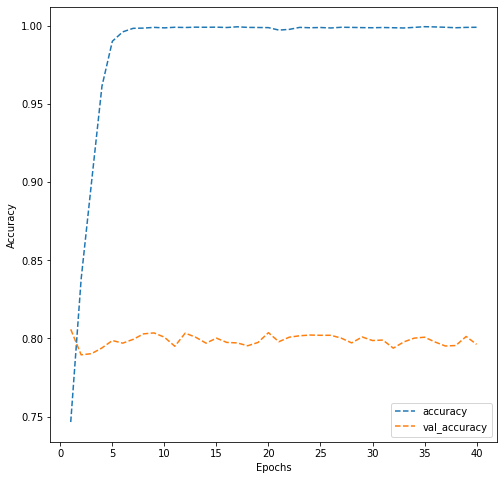

In [45]:
dict_hist = hist.history
list_ep = [i for i in range(1, 41)]
plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.66      0.67      0.67      1997
           1       0.86      0.85      0.85      4563

    accuracy                           0.80      6560
   macro avg       0.76      0.76      0.76      6560
weighted avg       0.80      0.80      0.80      6560

bal accuracy: 0.76183566386178


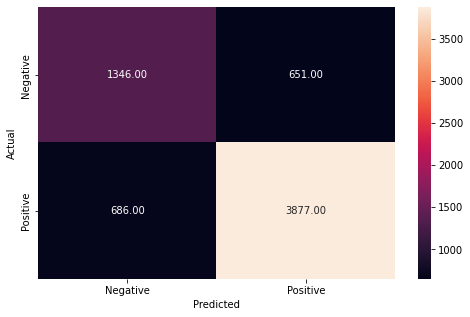

In [46]:
y_pred_test = model_4.predict(X_test_transformed)
y_pred_test=np.argmax(y_pred_test, axis=1)

metrics_score(np.argmax(y_test, axis=1), y_pred_test)